In [1]:
#GPUを使用
import tensorflow as tf
from keras import backend as K
#ネットワーク定義
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
K.clear_session()
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [2]:
num_classes = 2
img_height, img_width = 32 , 32
http://localhost:8948/notebooks/1orbit_2-3keV.ipynb#
#モデル
def Mynet():
    model = Sequential()
    model.add(Conv2D(280, (2, 2), padding='same', activation='relu',input_shape=(img_height, img_width, 1)))
    #model.add(Activation('relu'))
    model.add(Conv2D(976, (2, 2), padding='same', activation='relu'))
    #model.add(Activation('relu'))
    model.add(Conv2D(168, (2, 2), padding='same', activation='relu'))
    #model.add(Activation('relu'))
    model.add(Conv2D(224, (2, 2), padding='same', activation='relu'))
    #model.add(Activation('relu'))
    model.add(Conv2D(48, (2, 2), padding='same', activation='relu'))
    model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(Conv2D(688, (2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2416885539013352))
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Dense(num_classes,activation='softmax'))
    #model.add(Activation('softmax'))
    return model

In [3]:
#学習の準備
model = Mynet()
for layer in model.layers:
    layer.trainable = True
    

# モデルのサマリを表示
from keras.utils import plot_model
#model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#参考：https://keras.io/ja/optimizers/
#modelのコンパイル
#loss:損失関数、optimaizer:最適化アルゴリスム、metrics:評価関数
#RMSprop=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam(lr=3.9359465144288606e-05),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 280)       1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 976)       1094096   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 168)       656040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 224)       150752    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 48)        43056     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        6176      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 688)       88752     
__________

In [5]:
###学習用のデータを作る###
#numpy配列のデータ(image,label)#
##########################

###学習用のデータを作る###
import os
import numpy as np
from PIL import Image
from keras.utils.np_utils import to_categorical 

train_dir = '/home/tsato/work/machine_learning/CNN/images/1orbit/2-3keV_5000/train/'
validation_dir = '/home/tsato/work/machine_learning/CNN/images/1orbit/2-3keV_5000/validation/'
train_image_list = []
train_label_list = []
validation_image_list = []
validation_label_list = []


for dir in os.listdir(train_dir):
    if dir == ".DS_Store":
        continue
    
    dir1 = train_dir + dir 
    label = 0
    
    if dir == "background":
        label = 0
    elif dir == "flare":
        label = 1
    
    for file in os.listdir(dir1):
        if file != ".DS_Store":
            # 配列label_listに正解ラベルを追加
            train_label_list.append(label)
            filepath = dir1 + "/" + file
            # 画像を32x32pixelに変換し、グレースケール配列の32x32の２次元配列として読み込む。
            image = np.array(Image.open(filepath).convert('L').resize((32, 32)))
            #print(filepath)
            # 出来上がった配列をimage_listに追加。
            train_image_list.append(image / 255.)
            
for dir in os.listdir(validation_dir):
    if dir == ".DS_Store":
        continue    
    dir1 = validation_dir + dir 
    label = 0    
    if dir == "background":
        label = 0
    elif dir == "flare":
        label = 1    
    for file in os.listdir(dir1):
        if file != ".DS_Store":
            validation_label_list.append(label)
            filepath = dir1 + "/" + file
            image = np.array(Image.open(filepath).convert('L').resize((32, 32)))
            validation_image_list.append(image / 255.)

# kerasに渡すためにnumpy配列に変換。
train_image_list = np.array(train_image_list)
train_image_list = train_image_list.reshape(-1,32,32,1)
validation_image_list = np.array(validation_image_list)
validation_image_list = validation_image_list.reshape(-1,32,32,1)

# ラベルの配列を1と0からなるラベル配列に変更
train_Y = to_categorical(train_label_list)
validation_Y = to_categorical(validation_label_list)

######
print(train_image_list.shape,train_Y.shape)
print(validation_image_list.shape,validation_Y.shape)

(10000, 32, 32, 1) (10000, 2)
(2000, 32, 32, 1) (2000, 2)


In [ ]:
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join('./', 'model_.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_image_list,train_Y, verbose=1, epochs=50, batch_size=32, validation_data=(validation_image_list,validation_Y),callbacks=[es_cb,cp_cb])

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 2000 samples
Epoch 1/50
10000/10000 [==============================] - 42s 4ms/step - loss: 0.1543 - acc: 0.9309 - val_loss: 0.1037 - val_acc: 0.9665

Epoch 00001: val_loss improved from inf to 0.10371, saving model to ./model_.01-0.10.hdf5
Epoch 2/50
10000/10000 [==============================] - 35s 4ms/step - loss: 0.0938 - acc: 0.9667 - val_loss: 0.0851 - val_acc: 0.9725

Epoch 00002: val_loss improved from 0.10371 to 0.08509, saving model to ./model_.02-0.09.hdf5
Epoch 3/50
10000/10000 [==============================] - 35s 4ms/step - loss: 0.0831 - acc: 0.9708 - val_loss: 0.0760 - val_acc: 0.9770

Epoch 00003: val_loss improved from 0.08509 to 0.07600, saving model to ./model_.03-0.08.hdf5
Epoch 4/50
10000/10000 [==============================] - 35s 4ms/step - loss: 0.0763 - acc: 0.9725 - val_loss: 0.0925 - val_acc: 0.9675

Epoch 00004: val_loss did not improve from 0.07600
Epoch 5/50
10000/10000

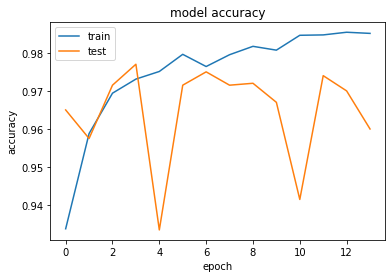

In [8]:
#学習軌跡の表示
import numpy as np
import matplotlib.pyplot as plt
##Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

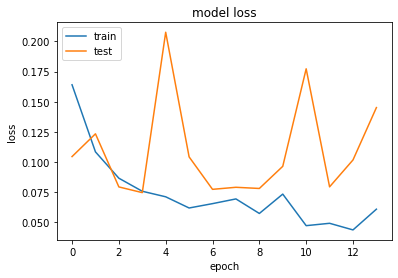

In [9]:
##loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()